# Configuration 

In [39]:
import easydict
from downstream_modules.data_utils import name_to_class

args = easydict.EasyDict(
    {
        # 'model_path': './artifacts/pmg_uni/epochs=20',
        'model_path': './artifacts/pmg_multi/epochs=20',
        # 'model_path': './artifacts/pmg_uni/baseline1_defect_epochs=20',
        'arch': 'pmg', # 'pmg', 'resnet'
        'method': 'multi', # 'uni', 'multi', 'baseline'
        'dataset': 'sofar_v3',
        'data_root_path': '../../../dataset/',
        
        'train_class': 'outer_normal,outer_damage,outer_dirt,outer_wash,inner_wash,inner_dashboard,inner_cupholder,inner_glovebox,inner_washer_fluid,inner_rear_seat,inner_sheet_dirt', 
        'test_class': 'outer_normal,outer_damage,outer_dirt,outer_wash,inner_wash,inner_dashboard,inner_cupholder,inner_glovebox,inner_washer_fluid,inner_rear_seat,inner_sheet_dirt', 
        # 'train_class': 'outer_normal,outer_damage',
        # 'test_class': 'outer_normal,outer_damage',

        'num_workers': 4, 
        'batch_size': 128 ,
        'ce_label': False, 
        'show_img': False, # to show result imgs 
    }
)
args.train_class_name = [item for item in args.train_class.split(',')]
args.test_class_name = [item for item in args.test_class.split(',')]

args.train_class = [name_to_class[item] for item in args.train_class.split(',')]
args.test_class = [name_to_class[item] for item in args.test_class.split(',')]

# Dataloader 

In [33]:
import cv2
import glob 
import pandas as pd
from PIL import Image, ImageFile

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
# from torchvision.datasets import ImageFolder

ImageFile.LOAD_TRUNCATED_IMAGES = True

normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

test_transform = transforms.Compose([
            transforms.Resize((448, 448)),
            transforms.ToTensor(),
            normalize
        ])

class SofarExtDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.data = glob.glob(root + '/*.jpg')
        
        self.transform = transform
        
    def __getitem__(self, index):
        path  = self.data[index]
        filename = path.split('/')[-1]
        # x = Image.open(path).convert("RGB")
        img = cv2.imread(path)[:,:,::-1]
        x = Image.fromarray(img)
        
        if self.transform is not None:
            x = self.transform(x)
        return x, 0

    def __len__(self):
        return len(self.data)

In [34]:
from downstream_modules.data_utils import create_dataloader

# test dataloader 
_, id_loader = create_dataloader(args)

# Model

In [40]:
import os 
import torch 
import torch.nn as nn 

if args.arch == 'resnet':
    pass 
# TODO: 
#     import torchvision
    
#     model = torchvision.models.resnet50(pretrained=False)
#     in_feats = model.fc.in_features
#     model.fc = nn.Identity()

elif args.arch == 'pmg':
    from models.resnet import resnet50
    from models.pmg import PMG
    
    model = resnet50(pretrained=False)
    ## TODO: uni, multi case 
    if args.method == 'uni' or args.method == 'baseline':
        model = PMG(model, feature_size = 512, num_classes = len(args.train_class))
    elif args.method == 'multi':
        model = PMG(model, feature_size = 512, num_classes = len(args.train_class)-1) 

state_dict = torch.load(os.path.join(args.model_path, 'last.pth'), map_location='cpu')
model.load_state_dict(state_dict)
print('pre-trained v2 model is loaded')

pre-trained v2 model is loaded


# Test

In [36]:
from tqdm import tqdm 
import numpy as np 

import torch.nn.functional as F 

@torch.no_grad()
def get_pred(model, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model.to(device)
    model.eval()

    test_preds = []

    for img, _ in tqdm(dataloader):
        img = img.to(device)

        # forward
        if args.arch == 'resnet':
            out = model(img)
            
        elif args.arch == 'pmg':
            out = model._forward(img)
            out = out[-1]
        
        # pred 
        if args.method == 'uni':
            out = F.softmax(out,dim=1)
            pred, _ = torch.max(out, dim=1)
            test_preds.extend(pred.view(-1).cpu().detach().numpy().tolist())
        elif args.method == 'baseline':
            out = F.softmax(out, dim=1)
            pred, _ = torch.max(out, dim=1)
            test_preds.extend(pred.view(-1).cpu().detach().numpy().tolist())
        elif args.method == 'multi':
            out_1 = F.sigmoid(out[:,0]).unsqueeze(1)
            out_2 = F.sigmoid(out[:,1]).unsqueeze(1)
            out_3 = F.sigmoid(out[:,2]).unsqueeze(1)
            out_4 = F.softmax(out[:,3:], dim=1)
            out = torch.cat([out_1,out_2,out_3,out_4], dim=1)
            # pred, _ = torch.max(out, dim=1)
            uniform = torch.tensor([0.5, 0.5, 0.5, 1./7, 1./7, 1./7, 1./7, 1./7, 1./7, 1./7]).unsqueeze(0).repeat(out.shape[0],1).to(device)
            pred = F.kl_div(out, uniform, reduction='none')

            test_preds.extend(pred.view(-1).cpu().detach().numpy().tolist())
    return test_preds 



In [41]:
# in-dist
id_preds = get_pred(model, id_loader)

  0%|          | 0/8 [00:00<?, ?it/s]/home/jovyan/.local/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 8/8 [00:30<00:00,  3.85s/it]


In [42]:
from sklearn.metrics import * 

# ood 
ext_val_path = ['../../../dataset/98_rejection_easy_bill', '../../../dataset/98_rejection_wheel', '../../../dataset/98_rejection_document']
for path in ext_val_path:
    # external validation dataloader 
    ext_dataset = SofarExtDataset(path, 
                                    transform=test_transform)
    print(len(ext_dataset))
    ood_loader = DataLoader(
                ext_dataset,
                batch_size=args.batch_size,
                shuffle=False,
                num_workers=args.num_workers,
                pin_memory=True,
                drop_last=False,
            ) 
    ood_preds = get_pred(model, ood_loader)
    test_preds = np.concatenate((id_preds, ood_preds))
    
    test_labels = np.concatenate(([1 for _ in range(len(np.array(id_preds)))],[0 for _ in range(len(np.array(ood_preds)))]))    
    print(path.split('/')[-1], roc_auc_score(test_labels, test_preds))

83


100%|██████████| 1/1 [00:12<00:00, 12.59s/it]


98_rejection_easy_bill 0.6040650525832142
102


  0%|          | 0/1 [00:00<?, ?it/s]/home/jovyan/.local/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 1/1 [00:07<00:00,  7.85s/it]


98_rejection_wheel 0.6052655574941841
108


  0%|          | 0/1 [00:00<?, ?it/s]/home/jovyan/.local/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 1/1 [00:06<00:00,  6.30s/it]

98_rejection_document 0.5766122292843692


multi
../../../dataset/98_rejection_easy_bill


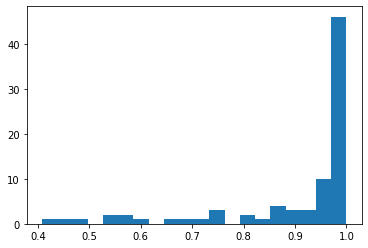

In [19]:
import matplotlib.pyplot as plt 
print(args.method)
print(args.data_root_path)
plt.hist(np.array(preds), bins=20) 
plt.show()

uni
../../../dataset/98_rejection_easy_bill


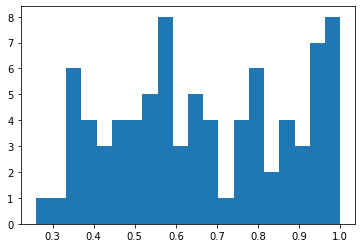

In [23]:
import matplotlib.pyplot as plt 
print(args.method)
print(args.data_root_path)
plt.hist(np.array(preds), bins=20) 
plt.show()

uni
../../../dataset/98_rejection_wheel


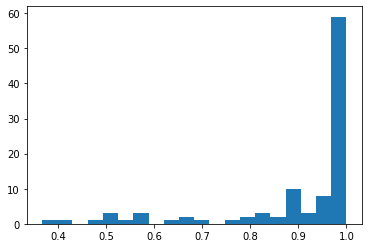

In [27]:
import matplotlib.pyplot as plt 
print(args.method)
print(args.data_root_path)
plt.hist(np.array(preds), bins=20) 
plt.show()

multi
../../../dataset/98_rejection_wheel


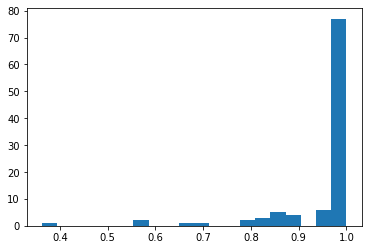

In [31]:
import matplotlib.pyplot as plt 
print(args.method)
print(args.data_root_path)
plt.hist(np.array(preds), bins=20) 
plt.show()